(569, 31)
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0   

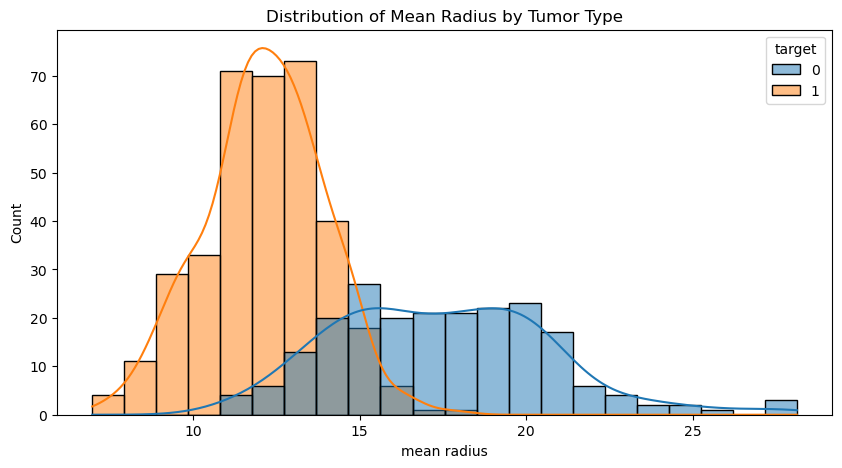

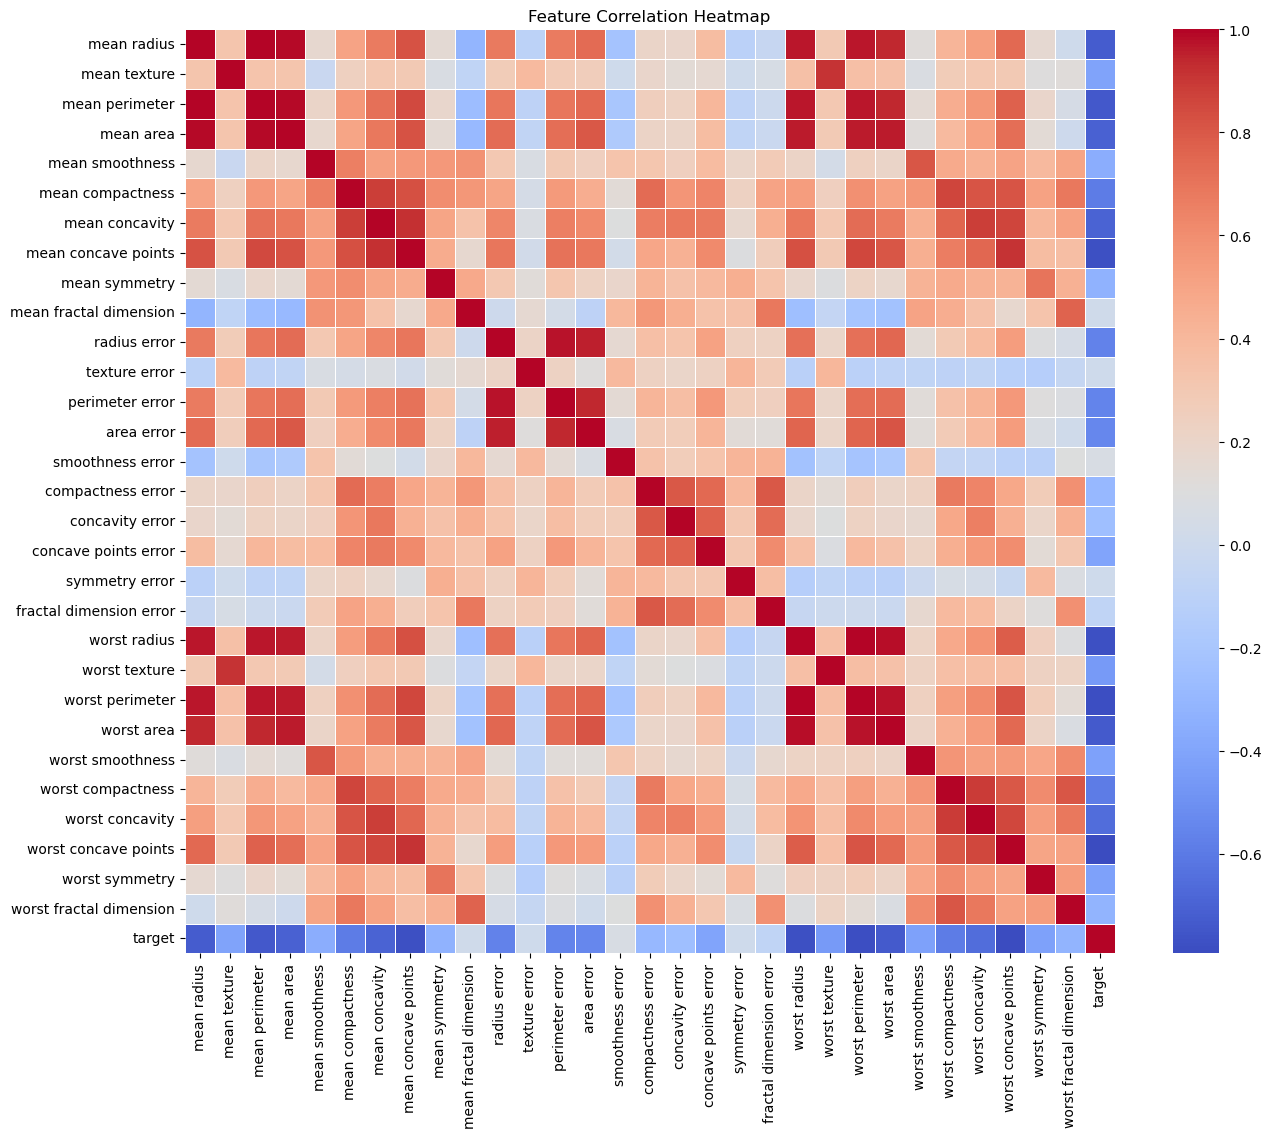

Accuracy: 0.956140350877193

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94        43
           1       0.95      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



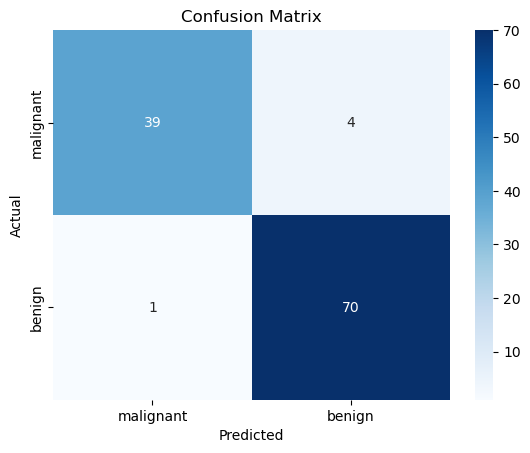

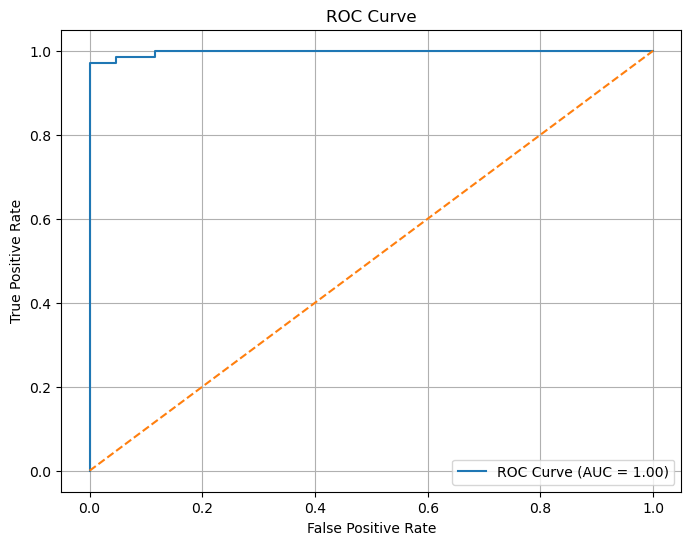

In [2]:
# 1. Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

# 2. Load and prepare the dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# 3. Data structure overview
print(df.shape)
print(df.head())
print(df['target'].value_counts())  # 0 = malignant, 1 = benign

# 4. Check for missing values
print(df.isnull().sum().sort_values(ascending=False))

# 5. Feature distribution (e.g. mean radius)
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='mean radius', hue='target', kde=True)
plt.title('Distribution of Mean Radius by Tumor Type')
plt.show()

# 6. Correlation heatmap
plt.figure(figsize=(15, 12))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

# 7. Split data
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Train logistic regression model
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# 9. Predictions
y_pred = model.predict(X_test)

# 10. Evaluation Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 11. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 12. ROC-AUC
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()



# Remove highly correlated features (correlation > 0.95)
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(columns=to_drop)

# Feature scaling
X = df.drop('target', axis=1)
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Store model results
results = {}

# Logistic Regression
log_model = LogisticRegression(max_iter=10000)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, log_pred),
    'report': classification_report(y_test, log_pred, output_dict=True),
    'roc_auc': roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1])
}

# Decision Tree
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)
results['Decision Tree'] = {
    'accuracy': accuracy_score(y_test, tree_pred),
    'report': classification_report(y_test, tree_pred, output_dict=True),
    'roc_auc': roc_auc_score(y_test, tree_model.predict_proba(X_test)[:, 1])
}

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, rf_pred),
    'report': classification_report(y_test, rf_pred, output_dict=True),
    'roc_auc': roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
}

# SVM (with probability=True for ROC-AUC)
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
results['SVM'] = {
    'accuracy': accuracy_score(y_test, svm_pred),
    'report': classification_report(y_test, svm_pred, output_dict=True),
    'roc_auc': roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])
}

# Save full report to file
report_path = "breast_cancer_model_comparison.txt"
with open(report_path, 'w') as f:
    for model, metrics in results.items():
        f.write(f"Model: {model}\n")
        f.write(f"Accuracy: {metrics['accuracy']:.4f}\n")
        f.write(f"ROC-AUC: {metrics['roc_auc']:.4f}\n")
        f.write("Classification Report:\n")
        df_report = pd.DataFrame(metrics['report']).transpose()
        f.write(df_report.to_string())
        f.write("\n\n")
